In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")
# from src.BuckleyLeverett import *

In [3]:
num_of_points = 5
r_min = 0.05
r_max = 0.95

init_porosity = 0.2
C = 7.0

pure_water_viscosity = 1e-3
oil_viscosity = 4e-3

init_water_saturation = 0.2

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
def water_viscosity(polymer_concentration):
	return pure_water_viscosity * torch.exp(10 * polymer_concentration)

In [6]:
def permeability(porosity):
    return C * torch.pow(porosity, torch.tensor(3)) / torch.pow(1 - porosity, torch.tensor(2))

In [7]:
permeability(torch.tensor(0.1))

tensor(0.0086)

In [8]:
r = torch.linspace(r_min, r_max, num_of_points)
r

tensor([0.0500, 0.2750, 0.5000, 0.7250, 0.9500])

In [9]:
num_of_all_points = num_of_points + 2
r_ext = torch.linspace(r_min-2*r[0], r_max+2*r[0], num_of_all_points)
r_ext

tensor([-0.0500,  0.1333,  0.3167,  0.5000,  0.6833,  0.8667,  1.0500])

In [10]:
porosity = torch.zeros_like(r) + init_porosity
porosity_ext = torch.zeros_like(r_ext) + init_porosity
porosity

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

In [11]:
perm = permeability(porosity)
perm_ext = permeability(porosity_ext)
perm

tensor([0.0875, 0.0875, 0.0875, 0.0875, 0.0875])

In [12]:
saturation = torch.zeros_like(r) + init_water_saturation
saturation_ext = torch.zeros_like(r_ext) + init_water_saturation

polymer_concentration = torch.zeros_like(r)
polymer_concentration_ext = torch.zeros_like(r_ext)

In [13]:
import torch

# Define constants as tensors
WATER_CURVE_SHAPE_PARAMETER = torch.tensor(2.5)
OIL_CURVE_SHAPE_PARAMETER = torch.tensor(2.0)
S_WIR = torch.tensor(0.0)
S_ORW = torch.tensor(0.0)

def normalized_s(S: torch.Tensor) -> torch.Tensor:
    return (S - S_WIR) / (1 - S_WIR - S_ORW)

def relative_water_perm(S: torch.Tensor) -> torch.Tensor:
    """Relative permeability to water

    Args:
        S (torch.Tensor): Water saturation

    Returns:
        torch.Tensor: Relative permeability to water
    """
    norm_s = normalized_s(S)
    return torch.where(
        S <= S_WIR,
        torch.tensor(0.0, dtype=S.dtype),
        torch.where(
            S >= (1 - S_ORW),
            torch.tensor(1.0, dtype=S.dtype),
            torch.pow(norm_s, WATER_CURVE_SHAPE_PARAMETER)
        )
    )

def relative_oil_perm(S: torch.Tensor) -> torch.Tensor:
    """Relative permeability to oil

    Args:
        S (torch.Tensor): Water saturation

    Returns:
        torch.Tensor: Relative permeability to oil
    """
    norm_s = normalized_s(S)
    return torch.where(
        S <= S_WIR,
        torch.tensor(1.0, dtype=S.dtype),
        torch.where(
            S >= (1 - S_ORW),
            torch.tensor(0.0, dtype=S.dtype),
            torch.pow(1 - norm_s, OIL_CURVE_SHAPE_PARAMETER)
        )
    )


In [14]:
kwi = relative_water_perm(saturation)
kwi_ext = relative_water_perm(saturation_ext)
kwi

tensor([0.0179, 0.0179, 0.0179, 0.0179, 0.0179])

In [15]:
muwi = water_viscosity(polymer_concentration)
muwi_ext = water_viscosity(polymer_concentration_ext)
muwi

tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010])

In [16]:
koi = relative_oil_perm(saturation)
koi_ext = relative_oil_perm(saturation_ext)
koi

tensor([0.6400, 0.6400, 0.6400, 0.6400, 0.6400])

In [17]:
muoi = np.zeros_like(r) + oil_viscosity
muoi_ext = np.zeros_like(r_ext) + oil_viscosity
muoi

array([0.004, 0.004, 0.004, 0.004, 0.004], dtype=float32)

In [18]:
dr2 = r_ext[2:] - \
		r_ext[:-2]
dr2

tensor([0.3667, 0.3667, 0.3667, 0.3667, 0.3667])

In [19]:
drplus = (r_ext[1:] - r_ext[:-1])[1:]
drplus

tensor([0.1833, 0.1833, 0.1833, 0.1833, 0.1833])

In [20]:
drminus = (r_ext[1:] - r_ext[:-1])[:-1]
drminus

tensor([0.1833, 0.1833, 0.1833, 0.1833, 0.1833])

In [21]:
Ai = 2 * perm / (dr2) * (kwi/muwi + koi/muoi) * (1 / (drplus) - 1 / (drminus))
Ai

tensor([ 4.0484e-05, -1.6194e-04,  2.0242e-04, -1.2145e-04,  0.0000e+00])

In [22]:
Aiplus1 = 2 * perm / (dr2 * drplus) * (kwi/muwi + koi/muoi) + 1 / dr2 * ((
    perm_ext[2:] * (kwi_ext[2:] / muwi_ext[2:] + koi_ext[2:] / muoi_ext[2:]) - 
    perm_ext[:-2] * (kwi_ext[:-2] / muwi_ext[:-2] + koi_ext[:-2] / muoi_ext[:-2])) / dr2 +
    perm * (kwi / muwi + koi / muoi) / r
)
Aiplus1

tensor([1312.1119,  617.4642,  547.9998,  521.6510,  507.7832])

In [23]:
main_diag = Ai
main_diag.shape

torch.Size([5])

In [24]:
upper_diag = Aiplus1[:-1]
upper_diag.shape

torch.Size([4])

In [25]:
lower_diag = Aiplus1[1:]
lower_diag.shape

torch.Size([4])

In [26]:
n = main_diag.size(0)
matrix = torch.zeros((n, n), dtype=torch.float32)
matrix

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [31]:
matrix += torch.diag_embed(main_diag)
upper_matrix = torch.diag_embed(upper_diag, offset=1)
matrix += upper_matrix
lower_matrix = torch.diag_embed(lower_diag, offset=-1)
matrix += lower_matrix

matrix

tensor([[ 656.0560, 2624.2239,    0.0000,    0.0000,    0.0000],
        [1234.9285,  308.7320, 1234.9285,    0.0000,    0.0000],
        [   0.0000, 1095.9995,  274.0001, 1095.9995,    0.0000],
        [   0.0000,    0.0000, 1043.3020,  260.8254, 1043.3020],
        [   0.0000,    0.0000,    0.0000, 1015.5665,  253.8916]])

In [32]:
f = torch.zeros((n, 1), dtype=torch.float32)
f[0] = 1
f[-1] = 2
f

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [2.]])

In [33]:
x = torch.linalg.solve(matrix, f)
x

tensor([[ 0.0033],
        [-0.0004],
        [-0.0032],
        [ 0.0012],
        [ 0.0029]])

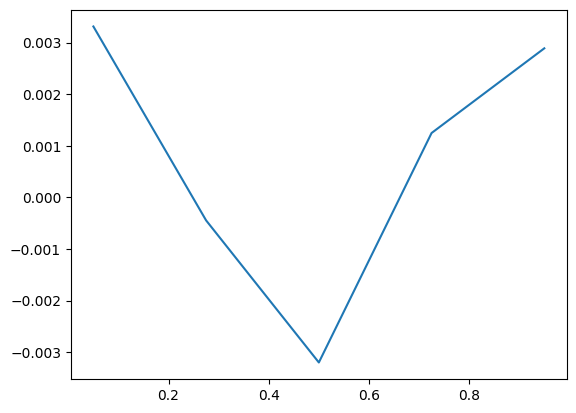

In [34]:
plt.plot(r, x)